## General Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load Data, Split Train-Val, and Train Model

For the purpose of this examples we'll use the simple iris dataset and train a random forest model for multiclass classification

In [2]:
iris_df = load_iris(return_X_y=False, as_frame=True)['frame']
label_col = 'target'
df_train, df_val = train_test_split(iris_df, stratify=iris_df[label_col], random_state=0)

In [3]:
rf_clf = RandomForestClassifier()
rf_clf.fit(df_train.drop(label_col, axis=1), df_train[label_col]);

## Define MLChecks Dataset

In [4]:
from mlchecks import Dataset

Initialize the Dataset object, stating the relevant metadata about the dataset (e.g. the name for the label column) <br>
Check out the Dataset's attributes to see which additional special columns can be declared and used (e.g. index, date).

In [5]:
# We explicitly state that this dataset has no categorical features, otherwise they will be automatically inferred

ds_train = Dataset(df_train, cat_features=[], label = label_col)
ds_val =  Dataset(df_val, cat_features=[], label = label_col)

## Run Data Integrity Check Suite

In [6]:
from mlchecks.suites import IntegrityCheckSuite

In [7]:
IntegrityCheckSuite.run(train_dataset=ds_train, validation_dataset=ds_val, check_datasets_policy='both')

Integrity Suite

String Mismatch Comparison

Detect different variants of string categories between the same categorical column in two datasets.

✓ Nothing found

Category Mismatch Train Validation

Find new categories in validation.

✓ Nothing found

Great! We're all good.

See what would've happened with a different train-val split:

In [8]:
train_len = round(0.67*iris_df.shape[0])
alternative_train_df = iris_df[:train_len]
alternative_val_df = iris_df[train_len:]

In [9]:
IntegrityCheckSuite.run(train_dataset=alternative_train_df, validation_dataset=alternative_val_df,
                        check_datasets_policy='both')

Integrity Suite

String Mismatch Comparison

Detect different variants of string categories between the same categorical column in two datasets.

✓ Nothing found

Category Mismatch Train Validation

Find new categories in validation.

✓ Nothing found

Note that we found:
1. Validation Dataset 'target' column, which is the label column, had only one single unique value! This indicates something that's worth noticing (validation data is different than the training data and has only a single type of labels in samples...)
2. Validation dataset had a duplicate sample (which might be fine, use-case dependent). If not relevant, this check can be removed from suite.
3. New category detected in validation dataset. Since not explicitly stated, these categories were inferred as categorical due to a limited amount of unique values in training dataset. Thus detecting values that were present only in validation dataset.

## Create Custom CheckSuite

In [10]:
from mlchecks import CheckSuite
from mlchecks.checks import *

In [11]:
# check out which builtin performance checks exist
print([class_name for class_name in dir(performance) if class_name[0].isupper()])

['CalibrationMetric', 'ConfusionMatrixReport', 'NaiveModelComparison', 'PerformanceReport', 'RocReport', 'SegmentPerformance']


In [12]:
MyModelSuite = CheckSuite('Simple Suite For Model Performance',
    ModelInfo(),
    PerformanceReport(),
    TrainValidationDifferenceOverfit(),
    ConfusionMatrixReport(),
    NaiveModelComparison(),
    NaiveModelComparison(naive_model_type='statistical')
)

Simple Suite For Model Performance

Train Validation Difference Overfit

Visualize overfit by displaying the difference between model metrics on train and on validation data.

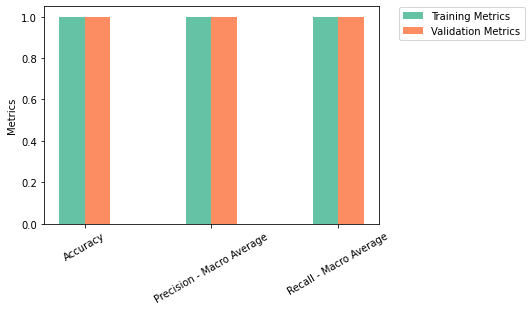

Naive Model Comparison

Compare naive model score to given model score.

The ratio between the naive model's Accuracy and the checked model's Accuracy is 0.34. RandomForestClassifier model prediction has achieved 1 compared to Naive statistical prediction which achieved 0.34 on tested data.

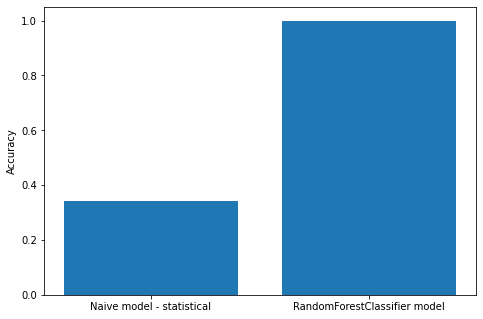

Naive Model Comparison

Compare naive model score to given model score.

The ratio between the naive model's Accuracy and the checked model's Accuracy is 0.34. RandomForestClassifier model prediction has achieved 1 compared to Naive statistical prediction which achieved 0.34 on tested data.

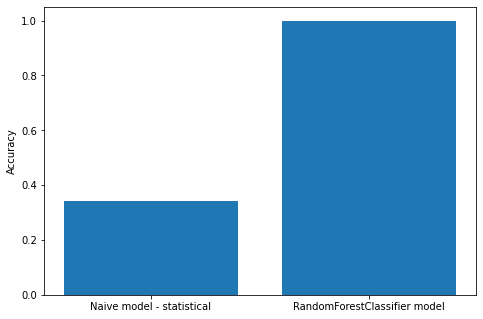

In [13]:
MyModelSuite.run(model=rf_clf, train_dataset=ds_train, validation_dataset=ds_val, check_datasets_policy='both')